# Naive Bayes Prediction For Rotten Tomatoes

## Summary

Rotten Tomatoes aggregates critics reviews of movies—resulting in a "fresh" percentage (with 100% indicating a perfect score). Each critic ultimately decides whether the movie was "fresh" or "rotten" overall. The analyses presented below show a Naive Bayes approach to dissecting reviews by independent words, determining which words are strong indicators of “fresh” or “rotten” reviews, and creating a model to predict the binary outcome for a new review.

In [55]:
#Import pandas, numpy, pyplot, sklearn
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [56]:
#Read in the two datasets (reviews and movies)
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

#Clean the dataset so we only use reviews with quotes and a fresh/rotten rating 
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

#Drop unused indices
reviews = reviews.reset_index(drop=True)

## Data

The cleaned data collected from rottentomatoes.com consists of 12,814 unique reviews with values for:

* critic: The critic's name

* fresh: The binary response (i.e., "fresh" or "rotten")

* imdb: The IMDB ID of the movie

* link: A link to the review

* publication: The publication that printed the review

* quote: The review itself (primary feature of interest)

* review_date: When the review was published

* rtid: An ID matching to another dataset of IMDB movie information

* title: The title of the movie

(Note that the cleaned data does not include reviews without a quote or fresh/rotten rating.)

## Part 1: Descriptive analysis

### 1.1: Basic features of the dataset

Firstly, we can find counts of unique features within the `reviews` dataset:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique critics are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many publications are in the `reviews` dataset?

In [57]:
#Find unique values in dataset
unique_reviews = reviews.quote.unique()
unique_reviewers = reviews.critic.unique()
unique_movies_reviews = reviews.title.unique()
unique_publications = reviews.publication.unique()

print("Number of unique reviews: %i" % len(unique_reviews))
print("Number of unique reviewers: %i" % len(unique_reviewers))
print("Number of unique movies reviewed: %i" % len(unique_movies_reviews))
print("Number of unique publications: %i" % len(unique_publications))

Number of unique reviews: 12814
Number of unique reviewers: 541
Number of unique movies reviewed: 1720
Number of unique publications: 64


### 1.2 Popular Critics

The following table shows the 30 most popular critics with values for the count of reviews, affiliated publication(s), and the oldest and newest reviews for each critic.

In [58]:
#Define functions to use with grouby
f = {"critic":["size"], "review_date":["min","max"], "publication":["unique"]}
reviews_critic = reviews.groupby(["critic"]).agg(f)

#Sort by number of reviews
reviews_critic_sorted = reviews_critic.sort_values(("critic","size"),ascending=False)
top30_critics = reviews_critic_sorted[0:30]

pd.options.display.max_colwidth = 100
top30_critics                                          

critic     review_date                  \
                     size             min             max   
critic                                                      
Roger Ebert          1150   1/1/2000 0:00  9/30/2005 0:00   
James Berardinelli    833   1/1/1932 0:00  9/25/2003 0:00   
Janet Maslin          526   1/1/2000 0:00   9/7/2010 0:00   
Variety Staff         449  1/11/2008 0:00   9/7/2010 0:00   
Jonathan Rosenbaum    420   1/1/2000 0:00   9/4/2007 0:00   
Desson Thomson        373   1/1/2000 0:00  9/25/2002 0:00   
Geoff Andrew          361  1/26/2006 0:00  9/30/2006 0:00   
Dave Kehr             360   1/1/2000 0:00   9/6/2007 0:00   
Kenneth Turan         282   1/1/2000 0:00   8/3/2013 0:00   
Mick LaSalle          280   1/1/2000 0:00  9/29/2006 0:00   
Owen Gleiberman       241   1/1/1991 0:00   9/8/1995 0:00   
Rita Kempley          236   1/1/2000 0:00  8/29/2002 0:00   
Joe Baltake           231   1/1/2000 0:00   8/6/2003 0:00   
Todd McCarthy         223   1/1/2000 0:00   9/9/2009 0:00   
Vincent Canby         207   1/1/2000 0:00  8/30/2004 0:00   
Hal Hinson            174   1/1/2000 0:00   8/1/2001 0:00   
Susan Stark           167   1/1/2000 0:00  8/24/2001 0:00   
Stephen Holden        166   1/1/2000 0:00  9/29/2005 0:00   
Derek Adams           154  1/26/2006 0:00  8/16/2007 0:00   
Kevin Thomas          145   1/1/2000 0:00  9/30/2005 0:00   
Peter Stack           138   1/1/2000 0:00   8/1/2001 0:00   
Bosley Crowther       137   1/1/2000 0:00   8/8/2006 0:00   
Rick Groen            129  1/16/2009 0:00  9/12/2008 0:00   
Edward Guthmann       121   1/1/2000 0:00  6/19/2002 0:00   
Lisa Schwarzbaum      117   1/1/1979 0:00   9/7/2011 0:00   
Liam Lacey            111  1/16/2009 0:00  9/19/2003 0:00   
Emanuel Levy          110   1/1/2000 0:00   9/1/2008 0:00   
Richard Schickel      106   1/1/2000 0:00   9/4/2008 0:00   
Richard Corliss       104  1/13/2010 0:00   9/7/2008 0:00   
Michael Wilmington    103   1/1/2000 0:00  9/19/2002 0:00   

                                                                        publication  
                                                                             unique  
critic                                                                               
Roger Ebert                                      [Chicago Sun-Times, At the Movies]  
James Berardinelli                                                      [ReelViews]  
Janet Maslin                                                       [New York Times]  
Variety Staff                                                             [Variety]  
Jonathan Rosenbaum                                                 [Chicago Reader]  
Desson Thomson                                                    [Washington Post]  
Geoff Andrew                                                             [Time Out]  
Dave Kehr                    [Chicago Reader, Chicago Tribune, New York Daily News]  
Kenneth Turan                                                   [Los Angeles Times]  
Mick LaSalle                                              [San Francisco Chronicle]  
Owen Gleiberman                                              [Entertainment Weekly]  
Rita Kempley                                                      [Washington Post]  
Joe Baltake         [Sacramento Bee, Passionate Moviegoer, Philadelphia Daily News]  
Todd McCarthy                                                             [Variety]  
Vincent Canby                                                      [New York Times]  
Hal Hinson                                                        [Washington Post]  
Susan Stark                                                          [Detroit News]  
Stephen Holden                                                     [New York Times]  
Derek Adams                                                              [Time Out]  
Kevin Thomas                                                    [Los Angeles Times]  
Peter Stack                

### 1.4 Ratings over time

The following histogram uses a separate `movies` dataset from IMDB showing how the average rating per movie has evolved over time. 

From this plot, we see that around 1980-90, the number of unique movies reviewed by critics increases dramatically. There also seems to be a time-related pattern, with movie ratings for pre-1980s showing higher averages. However, it is highly likely that the number of critics reviewing earlier movies is lower than the number of critics reviewing more recent releases. 

(Also, in my opinion, critics forget to remove their rose-tinted glasses when viewing movies from the "golden age of Hollywood.")

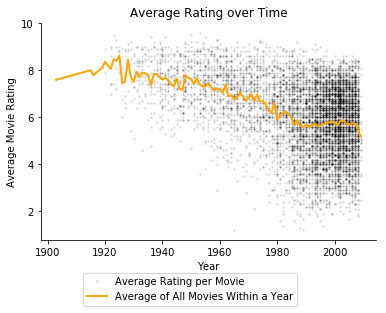

In [59]:
#Force rtAllCriticsRating to be numeric
movies["allratings"] = pd.to_numeric(movies.rtAllCriticsRating, errors="coerce")

#Create subset of data that only includes ratings > 0
rated_movies = movies[(movies.allratings > 0)]
average_rating_year = rated_movies.groupby("year").allratings.mean()
#Create scatterplot with avrage rating per movie and average of all movies within each year

ax2 = plt.subplot(111)
ax2.plot(rated_movies.year, rated_movies.allratings, "ko",
         markersize=1.5, alpha=0.1, label="Average Rating per Movie")
ax2.plot(average_rating_year.index,average_rating_year,
         color="orange",linewidth=2,label="Average of All Movies Within a Year")
plt.legend(bbox_to_anchor=(0.765,-0.15), loc=1, borderaxespad=0.)

#Get rid of axes and tick marks on top and right
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.yaxis.set_ticks_position("left")
ax2.xaxis.set_ticks_position("bottom")

plt.title("Average Rating over Time")
plt.xlabel("Year")
plt.ylabel("Average Movie Rating")

plt.show()

## Part 2: Naive Bayes

Utilizing scikit-learn's countvectorizer function (http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), we can convert raw text fields into "bag of words" vectors—transforming the data into counts of unique word used within each review. 

### 2.1 Creating X input and Y output

Using the `reviews` dataframe, we create X and Y arrays:
    
 * X is the input `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review.
 * Y is the output `nreview`-element 1/0 array, indicating whether a review is fresh (1) or rotten (0).

In [60]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
mindf : float (optional)
    Allows user to specify min_df to use within CountVectorizer function.
    Default is 0.
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None, mindf=0):
    vectorizer = CountVectorizer(min_df=mindf)
    # call `fit` to build the vocabulary
    vectorizer.fit(reviews.quote.values)
    x = vectorizer.transform(reviews.quote.values)
    X = x.tocsc()
    #Set Y as binary variable with "fresh"=1 and "rotten"=0
    Y = (reviews.fresh=="fresh").values.astype(np.int)
    return X, Y

In [61]:
#Create vecotrized arrays
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Now, we randomly split the data into training and testing data.

In [62]:
#Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state=0)

### 2.3 Naive Bayes with `MultinomialNB`
Given the response variable of interest is binary, we model the training data using the MultinomialNB Naive Bayes classifier (http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).  

In [63]:
#Use Multinomial classifier
clf = MultinomialNB()
#Fit the function to given training values of x and y
clf.fit(X_train, y_train)
my_model = clf.fit(X_train, y_train)

#Find accuracy for training and testing data using the fitted model
#Use scikit's score function (mean accuracy on given data/labels)
training_accuracy = my_model.score(X_train, y_train)
testing_accuracy = my_model.score(X_test, y_test)

print("Training set prediction accuracy: %.4f" % (training_accuracy))
print("Testing set prediction accuracy: %.4f" % (testing_accuracy))

Training set prediction accuracy: 0.9243
Testing set prediction accuracy: 0.7701


Using the default smoothing parameter $\alpha$  = 1 with fitted priors, the Naive Bayes method correctly predicted 92.43% of the training set's "rotton/fresh" category given the vectorized review quotes. 

Using the same model fitted with the training set, the Naive Bayes method for the testing set correctly predicted 77.01% of the actual review category.

## Part 3: Evaluation

### 3.1 Likelihood

Using `fitted_model.predict_logproba`, we can find the log-likelihood for the training and testing sets.

In [64]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return(prob[rotten, 0].sum() + prob[fresh, 1].sum())

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
llk_train = log_likelihood(my_model, X_train, y_train)
llk_test = log_likelihood(my_model, X_test, y_test)

print("Log-Likelihood for Training Set: %.4f" % (llk_train))
print("Log-Likelihood for Testing Set: %.4f" % (llk_test))

Log-Likelihood for Training Set: -1620.2872
Log-Likelihood for Testing Set: -2663.4488


### 3.2 Cross-Validation

The Naive Bayes classifier has hyperparameters that can improve prediction:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The `alpha` (http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter"—increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

Using cross-validation, we can loop over different ($\alpha$, min_df) combinations with the goal of improving the classifier.

In [65]:
#Grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Initalize the "best" values that the loop will fill
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:      
        X, Y = make_xy(reviews, mindf=min_df)
        #Add alpha argument to clf
        clf = MultinomialNB(alpha = alpha)
        #Find current iteration's mean cross-validated log-likelihood using given cross_val_score
        llk_cross = cross_val_score(clf,X,Y,log_likelihood).mean()
        #Determine if the new likelihood is the best
        if llk_cross > max_loglike:
            #If we have the best, update the values of best_alpha, best_min_df, and max_loglike to current iteration
            best_alpha = alpha
            best_min_df = min_df
            max_loglike = llk_cross
#After running the loop for each combination of given alphas and min_dfs, report the optimized results
print("Maximum log-likelihood of %.4f achieved when alpha = %.2f, and min_df = %.0e" % (max_loglike,best_alpha,best_min_df))

Maximum log-likelihood of -2546.7277 achieved when alpha = 5.00, and min_df = 1e-03


### 3.3 Putting it together

In this case, setting alpha=5 and min_df=0.001 results in the maximum likelihood of values tested within the loop. Now we can use the optimized hyperparameters to run the classifier again.

In [66]:
#Create vecotrized arrays
X, Y = make_xy(reviews, mindf=1e-3)
#Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state=0)
#Fit the function to the training set

#Use Multinomial classifier with alpha value found in part 2
clf = MultinomialNB(alpha=5)

#Fit the function to given training values of x and y
clf.fit(X_train, y_train)
my_new_model = clf.fit(X_train, y_train)

#Find accuracy for training data
training_accuracy = my_new_model.score(X_train, y_train)
testing_accuracy = my_new_model.score(X_test, y_test)

print("Training set prediction accuracy: %.4f" % (training_accuracy))
print("Testing set prediction accuracy: %.4f" % (testing_accuracy))

Training set prediction accuracy: 0.7936
Testing set prediction accuracy: 0.7370


The results point to a less accurate training set (i.e., previous one was likely overfitting), but the testing accuracy also performed slightly worse. In this case, overfitting provided better accuracy.

(Note: We could try testing max_df and sensible stop-words to reduce overfitting in a way that produces more accurate test results.)

### Accuracy instead of Likelihood

Using classification accuracy instead of likelihood as our evaluation metric, we can run the previous loop again, find optimal values for alpha and min_df, and test the model again.

In [67]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:      
        X, Y = make_xy(reviews, mindf=min_df)
        #Add alpha argument to clf
        clf = MultinomialNB(alpha = alpha)
        #Find current iteration's mean cross-validated ****ACCURACY**** using given cross_val_score
        llk_cross = cross_val_score(clf,X,Y,scoring="accuracy").mean()
        #Determine if the new likelihood is the best
        if llk_cross > max_loglike:
            #If we have the best, update the values of best_alpha, best_min_df, and max_loglike to current iteration
            best_alpha = alpha
            best_min_df = min_df
            max_loglike = llk_cross
#After running the loop for each combination of given alphas and min_dfs, report the optimized results
print("Maximum accuracy of %.4f achieved when alpha = %.2f, and min_df = %.0e" % (max_loglike,best_alpha,best_min_df))

Maximum accuracy of 0.7466 achieved when alpha = 1.00, and min_df = 1e-05


In [68]:
#Create vecotrized arrays
X, Y = make_xy(reviews, mindf=1e-5)
#Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state=0)
#Fit the function to the training set

#Use Multinomial classifier with alpha value found in part 2
clf = MultinomialNB(alpha=1)

#Fit the function to given training values of x and y
my_new_model_2 = clf.fit(X_train, y_train)

#Find accuracy for training data
training_accuracy = my_new_model_2.score(X_train, y_train)
testing_accuracy = my_new_model_2.score(X_test, y_test)

print("Training set prediction accuracy: %.4f" % (training_accuracy))
print("Testing set prediction accuracy: %.4f" % (testing_accuracy))

Training set prediction accuracy: 0.9243
Testing set prediction accuracy: 0.7701


Using accuracy instead of log-likelihood as the method to optimize the model produces min_df=0.00001 and $\alpha$ = 1 (the default value for MultinomialNB). Given that min_df is only changing from default value 0 by $\frac{1}{100,000}$, our training and testing prediction accuracy values are very similar to those found in section 2.3.

### 3.5 Interpretation

Now we can dive into finding the words that best predict a fresh or rotten review using our classifier and the `vectorizer.get_feature_names` method. determine which words best predict a positive or negative review.

In [69]:
#Recreating original fit
my_vectorizer = CountVectorizer()
my_vectorizer.fit(reviews.quote.values)
x = my_vectorizer.transform(reviews.quote.values)
X = x.tocsc()
Y = (reviews.fresh == "fresh").values.astype(np.int)
my_features = my_vectorizer.get_feature_names()
clf = MultinomialNB()
my_new_model = clf.fit(X,Y)

#Use identity matrix with all possible features
n_feat = X.shape[1]
X_identity = np.identity(n_feat)

#Find the probabilities for predicting rotten or fresh using identity matrix
#In other words, what are the probabilities if each word appears exactly once in data
probs = my_new_model.predict_log_proba(X_identity)[:,0]

#Create dataframe with feature name and its sorted coefficients
feature_coef_df = pd.DataFrame({"feature": my_features,
                               "probabilities": probs})
sorted_feature_df = feature_coef_df.sort_values("probabilities",ascending=True)

The first table reports the ten words from reviews that best indicate a "fresh" review along with the log probabilities. 

The second table, on the other hand, reports the ten words from reviews that best indicate the critic viewed the movie as "rotten" overall.

In [70]:
#First ten features (most negative log prob) are best ten indicators for fresh
top_10_fresh_words = sorted_feature_df[0:9]
top_10_fresh_words

,feature,probabilities
4751,delight,-3.848451
9704,intimate,-3.395639
2741,captures,-3.321356
12175,myth,-3.241108
3116,childhood,-3.241108
15655,rousing,-3.198433
16137,seductive,-3.153856
19536,unforgettable,-3.107197
6456,expertly,-3.107197


In [71]:
#Last ten features (least negative log prob) are best ten indicators for rotten
top_10_rotten_words = sorted_feature_df[(n_feat-10):n_feat]
top_10_rotten_words

,feature,probabilities
16875,sluggish,-0.078947
20583,witless,-0.078947
12583,obnoxious,-0.078947
5131,disappointingly,-0.073510
18792,tiresome,-0.060924
15750,sadly,-0.060924
19574,uninspired,-0.047400
19543,unfortunately,-0.047400
13776,pointless,-0.040253
10370,lame,-0.038790


Using our model for an n x n identity matrix where n is the number of features within our dataset allows us to find the probabilities (log for faster computation) of each feature—found exactly once in the dataset—predicting Y=0 (i.e., "rotten"). 

The smallest ten probabilities (most negative log-probabilities) indicate the ten best words for predicting "fresh" reviews under our model. 

Conversely, the largest ten probabilities (least negative log-probabilities) indicate the ten best words for predicting "rotten" reviews.

It looks like our model performed very well as each "fresh" predicting word has positive connotations (e.g., "delight," "unforgettable," "rousing."

The top ten "rotten" predicting words have strong negative connotations (e.g., "lame", "uninspired", "pointless"). 

### 3.6 Error Analysis

To see where our Naive Bayes classifier falls short, we can view a handful of reviews where the model predicted the wrong outcome.

In [72]:
#Find my model's log-probabilities that Y=1 ("fresh")
prob_X = my_new_model.predict_log_proba(X)[:,1]
#Create dataframe with log-probabilities and actual labels
prob_check = pd.DataFrame({"probability": prob_X,
                           "actual": Y})

#Create subsets of df for reviews that were actually fresh and actually rotten
check_fresh = prob_check[prob_check.actual==1]
check_rotten = prob_check[prob_check.actual==0]

#Sort fresh subset with lowest probabilities first (poor predictions at top)
#Sort rotten subset with highest probabilities first (poor predictions at top)
sorted_check_fresh = check_fresh.sort_values("probability",ascending=True)
sorted_check_rotten = check_rotten.sort_values("probability",ascending=False)

#Find top 5 worst prediction probabilities for each data subset
top5_poor_predictions_fresh = sorted_check_fresh[0:5]
top5_poor_predictions_rotten = sorted_check_rotten[0:5]

#Find indices
top5_bad_fresh = top5_poor_predictions_fresh.index
top5_bad_rotten = top5_poor_predictions_rotten.index

#Match with actual reviews
top5_bad_fresh_quotes = reviews["quote"][top5_bad_fresh]
top5_bad_rotten_quotes = reviews["quote"][top5_bad_rotten]

#### Five fresh reviews that the classifier predicted would be rotten

In [73]:
pd.options.display.max_colwidth = 1000
print(top5_bad_fresh_quotes)

1872                                                  Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?
12605                                                    There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell.
5704                                                  The gangland plot is flimsy (bad guy Peter Greene wears too much eyeliner), and the jokes are erratic, but it's a far better showcase for Carrey's comic-from-Uranus talent than Ace Ventura.
1665                                                                  A kind of insane logic seems to connect the sketches, if you look hard enough, but mostly the movie seems to exist in the present and be willing to try anything for a laugh.
1695     There is only o

#### Five rotten reviews that the classifier predicted would be fresh

In [74]:
pd.options.display.max_colwidth = 1000
print(top5_bad_rotten_quotes)

9129                                                                                                                   The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.
8456                                                                                It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.
11692                                               This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.
13275    What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?
10030                                                                   

For fresh reviews that the model incorrectly predicted would be rotten, there are many negative words, but the overall sentiment leans positive. For example, review 1872 uses words like "bad" and "poor," but the critic is actually applauding how funny the movie is because of the over-the-top, "bad" jokes.

For incorrectly labeled rotten reviews, we observe the opposite effect. In review 9129, the critic uses words like "enjoyable" and "masterpiece" when he is really saying that the film is NOT a masterpiece. Other reviews in this misclassification seem to be lukewarm—offering a few compliments in what they deemed to be a poor film overall.

In both cases, we see the pitfall of Naive Bayes' assumption of mutual independence between all words within a review. Looking back at review 1872, the author used the phrase  "riotously poor"—two negative words that come together to form a sense of twisted humor. 

To show an exaggerated example of this problem, we can test the quote ("This movie is not remarkable, touching, or superb in any way"):

In [75]:
#Test the given quote using my model
new_quote = ["This movie is not remarkable, touching, or superb in any way"]
newx = my_vectorizer.transform(new_quote)
newX = newx.tocsc()
prob_newX_fresh = my_new_model.predict_proba(newX)[0][1]
print("For the quote, 'This movie is not remarkable, touching, or superb in any way,' \n" 
      "our model predicted a 'fresh' probability of %.4f." % prob_newX_fresh)

For the quote, 'This movie is not remarkable, touching, or superb in any way,' 
our model predicted a 'fresh' probability of 0.9994.


In this example, the model gave a very strong prediction in favor of "fresh." Obviously, when we read the whole sentence, it is clear this statement is very negative. However, when we treat each word as an independent predicting feature, we have very positive words "remarkable," "touching," and "superb." Only the word "not" has negative connotation, and it certainly isn't as powerful as the sentence's positive words. 

So we have some prime examples of how treating each word as an independent feature can cause misclassification when using Naive Bayes.

## Conclusion

The Rotten Tomatoes data used for this example analysis simply provides a non-"spam vs. ham email" example of how Naive Bayes classification can work for binary outcomes. The analyses I performed resulted in over 75% prediction accuracy for the testing data using a fairly rudimentary Naive Bayes model. I was not expecting that kind of performance given the outlandish assumption of mutual independence between all words within a single review and the sheer complexity of the English language.

Of course, there are examples like the ten listed above where violation of the independence assumption results in an inaccurate prediction. However, we can always make improvements on the model. For example, we may consider excluding negation words like "not" by imposing stop words. 